In [3]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"


/home/mila/l/le.zhang/.conda/envs/flava/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mila/l/le.zhang/.conda/envs/flava/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/mila/l/le.zhang/.conda/envs/flava/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [1]:
def get_data(task,plot_figures=True):
    assert task in ['mnist','cifar']
    if task=='cifar':
        transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        cifar_trainset = datasets.CIFAR10(root='../../data', download=True, transform=transform)
        train_dataset = np.transpose(cifar_trainset.data[:-10000],(0,3,1,2))/255
        eval_dataset = np.transpose(cifar_trainset.data[-10000:],(0,3,1,2))/255
        all_dataset = np.transpose(cifar_trainset.data,(0,3,1,2))/255
        print('train_dataset shape:',train_dataset.shape)
        if plot_figures:
            fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5, 5))
            for i in range(5):
                for j in range(5):
                    axes[i][j].imshow(np.transpose(train_dataset[i*5+j],(1,2,0)))
                    axes[i][j].axis('off')
        return train_dataset,eval_dataset,all_dataset
    elif task=='mnist':
        mnist_trainset = datasets.MNIST(root='../../data', download=True, transform=None)
        train_dataset = mnist_trainset.data[:-10000].reshape(-1, 1, 28, 28) / 255.
        eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.
        all_dataset=mnist_trainset.data.reshape(-1, 1, 28, 28) / 255.
        print('train_dataset shape:',train_dataset.shape)
        if plot_figures:
            fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5, 5))
            for i in range(5):
                for j in range(5):
                    axes[i][j].imshow(train_dataset[i*5 +j].cpu().squeeze(0), cmap='gray')
                    axes[i][j].axis('off')
        return train_dataset,eval_dataset,all_dataset


In [2]:

def get_model(model_name,task):
    assert model_name in ['vae','rae_gp']
    assert task in ['mnist','cifar']
    if task=='mnist':
        input_dim=(1,28,28)
        latent_dim=16
        if model_name=='vae':
            from pythae.models import VAE, VAEConfig
            from pythae.models.nn.benchmarks.mnist import Encoder_ResNet_VAE_MNIST, Decoder_ResNet_AE_MNIST
            model_config = VAEConfig(
                input_dim=input_dim,
                latent_dim=latent_dim
            )
            model = VAE(
                model_config=model_config,
                encoder=Encoder_ResNet_VAE_MNIST(model_config), 
                decoder=Decoder_ResNet_AE_MNIST(model_config) 
            )
        elif model_name=='rae_gp':
            from pythae.models import RAE_GP, RAE_GP_Config
            from pythae.models.nn.benchmarks.mnist import Encoder_ResNet_AE_MNIST, Decoder_ResNet_AE_MNIST
            model_config = RAE_GP_Config(
                    input_dim=input_dim,
                    latent_dim=latent_dim, # mnist 16
                    embedding_weight=1e-2,
                    reg_weight=1e-4
                )
            model = RAE_GP(
                model_config=model_config,
                encoder=Encoder_ResNet_AE_MNIST(model_config), 
                decoder=Decoder_ResNet_AE_MNIST(model_config) 
            )
    elif task=='cifar':
        input_dim=(3,32,32)
        latent_dim=128
        if model_name=='vae':
            from pythae.models import VAE, VAEConfig
            from pythae.models.nn.benchmarks.cifar import Encoder_ResNet_VAE_CIFAR, Decoder_ResNet_AE_CIFAR
            model_config = VAEConfig(
                input_dim=input_dim,
                latent_dim=latent_dim
            )
            model = VAE(
                model_config=model_config,
                encoder=Encoder_ResNet_VAE_CIFAR(model_config), 
                decoder=Decoder_ResNet_AE_CIFAR(model_config) 
            )
        elif model_name=='rae_gp':
            from pythae.models import RAE_GP, RAE_GP_Config
            from pythae.models.nn.benchmarks.cifar import Encoder_ResNet_AE_CIFAR, Decoder_ResNet_AE_CIFAR
            model_config = RAE_GP_Config(
                    input_dim=input_dim,
                    latent_dim=latent_dim, # mnist 16
                    embedding_weight=1e-2,
                    reg_weight=1e-4
                )
            model = RAE_GP(
                model_config=model_config,
                encoder=Encoder_ResNet_AE_CIFAR(model_config), 
                decoder=Decoder_ResNet_AE_CIFAR(model_config) 
            )
    return model

# Stage 1: training VAE

train_dataset shape: torch.Size([50000, 1, 28, 28])


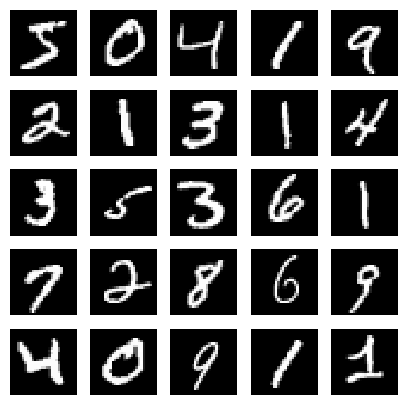

In [19]:
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
model_name='rae_gp'
task='mnist'
output_dir='my_model/{}/{}/'.format(task,model_name)
config= BaseTrainerConfig(
    output_dir=output_dir,
    learning_rate=1e-4,
    batch_size=4096,
    num_epochs=100, # Change this to train the model a bit more
)

train_dataset,eval_dataset,all_dataset=get_data(task)
model=get_model(model_name,task)

In [20]:
pipeline = TrainingPipeline(
    training_config=config,
    model=model
)
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset
)

Preprocessing train data...
Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer

Created my_model/mnist/rae_gp/ folder since did not exist.

Model passed sanity check !

Created my_model/mnist/rae_gp/RAE_GP_training_2022-12-23_13-55-11. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !

Eval of epoch 1/100: 100%|██████████| 3/3 [00:00<00:00,  9.34batch/s]
--------------------------------------------------------------------------
Train loss: 159.6087
Eval loss: 149.2008
--------------------------------------------------------------------------
Eval of epoch 2/100: 100%|██████████| 3/3 [00:00<00:00,  9.41batch/s]
--------------------------------------------------------------------------
Train loss: 127.2542
Eval loss: 92.6961
--------------------------------------------------------------------------
Eval of epoch 3/100: 100%|██████████| 3/3 [00:00<00:00,  9.30batch/s]
-------------------------

In [21]:
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm import tqdm
fid=FrechetInceptionDistance(feature=2048).to(device)
fid.eval()
def evaluate(pred, target):
    pred=pred.to(device)
    target=target.to(device)
    print('pred shape: ',pred.shape)
    print('target shape: ',target.shape)
    with  torch.no_grad():
        metric = {}
        batch_size = 512
        imgs_dist1 = (pred.mul(255).add(0.5).clamp(0, 255)).type(torch.uint8)
        imgs_dist2 = (target.mul(255).add(0.5).clamp(0, 255)).type(torch.uint8)
        if imgs_dist1.shape[1] == 1: 
            imgs_dist1 = imgs_dist1.repeat(1, 3, 1, 1)
        if imgs_dist2.shape[1] == 1:
            imgs_dist2 = imgs_dist2.repeat(1, 3, 1, 1)
        # fid.reset()
        for idx in tqdm(range(0, len(pred), batch_size)):
            fid.update(imgs_dist1[idx:idx+batch_size], real=False)
            fid.update(imgs_dist2[idx:idx+batch_size], real=True)
        metric["FID"] = fid.compute()
        print('FID : {}'.format(metric["FID"].cpu().item()))
def plot_figures(images,output_dir=None,file_name=None):
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(2, 2))
    for i in range(5):
        for j in range(5):
            if images.shape[1]==1:
                axes[i][j].imshow(images[i*5+j].cpu().squeeze(0),cmap='gray')
            else:
                axes[i][j].imshow(np.transpose(images[i*5+j].cpu(),(1,2,0)))
            axes[i][j].axis('off')
    plt.tight_layout(pad=0.)
    if output_dir is not None:
        fig.savefig(os.path.join(output_dir,file_name))
        
def get_sampler(sampler,model,train_dataset=None):
    assert sampler in ['normal','gmm']
    if sampler=='normal':
        from pythae.samplers import NormalSampler
        normal_samper = NormalSampler(model=model)
        return normal_samper
    elif sampler=='gmm':
        assert train_dataset is not None
        from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig,NormalSampler
        gmm_sampler_config = GaussianMixtureSamplerConfig(n_components=30)
        gmm_sampler = GaussianMixtureSampler(sampler_config=gmm_sampler_config,model=model)
        print('fitting gmm sampler, this process could take several mins')
        gmm_sampler.fit(train_dataset)
        return gmm_sampler

/home/mila/l/le.zhang/.conda/envs/flava/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `FrechetInceptionDistance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


# Stage 1: Evaluation

In [4]:
import os
from pythae.models import AutoModel

train_dataset shape: torch.Size([50000, 1, 28, 28])


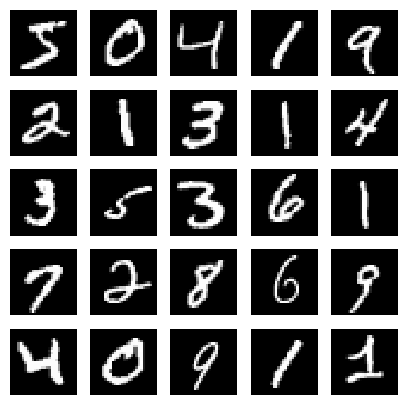

In [22]:
model_name='rae_gp'
task='mnist'
output_dir='my_model/{}/{}/'.format(task,model_name)
last_training = sorted(os.listdir(output_dir))[-1]
output_dir=os.path.join(output_dir, last_training, 'final_model')
trained_model = AutoModel.load_from_folder(output_dir)
train_dataset,eval_dataset,all_dataset=get_data(task)

In [23]:
sampler_gmm=get_sampler('gmm',trained_model,train_dataset)

fitting gmm sampler, this process could take several mins


/tmp/ipykernel_749602/1551908897.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  evaluate(sampler_gmm.sample(all_dataset.shape[0]),torch.tensor(all_dataset))


pred shape:  torch.Size([60000, 1, 28, 28])
target shape:  torch.Size([60000, 1, 28, 28])


100%|██████████| 118/118 [00:56<00:00,  2.10it/s]


FID : 23.811077117919922


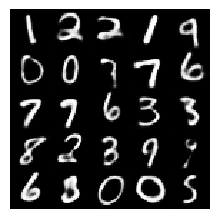

In [24]:
plot_figures(sampler_gmm.sample(25),output_dir,'valina_gmm_output')
evaluate(sampler_gmm.sample(all_dataset.shape[0]),torch.tensor(all_dataset))

# Stage 2: NCP training

In [25]:
import torch
import torch.nn as nn

class SE_Block(nn.Module):
    def __init__(self, c, r=16):
        super().__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        bs, c, _, _ = x.shape
        y = self.squeeze(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1, 1)
        return x * y.expand_as(x)
class ResidualBlockA(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlockA, self).__init__()
        assert out_channels==in_channels 
        self.conv1 = nn.Sequential(
                        nn.BatchNorm2d(in_channels),
                        nn.SiLU(),
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1))
        self.conv2 = nn.Sequential(
                        nn.BatchNorm2d(out_channels),
                        nn.SiLU(),
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        SE_Block(out_channels))   
        self.out_channels = out_channels
        self.sigmoid=nn.Sigmoid()
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        out += residual
        return out

class ResidualBlockB(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlockB, self).__init__()
        assert out_channels==2*in_channels
        self.conv1 = nn.Sequential(
                        nn.BatchNorm2d(in_channels),
                        nn.SiLU(),
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 2, padding = 1))
        self.conv2 = nn.Sequential(
                        nn.BatchNorm2d(out_channels),
                        nn.SiLU(),
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        SE_Block(out_channels))
        self.factorized_reduction=nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=2,padding=0)
        self.out_channels = out_channels
        self.swish=SE_Block(in_channels)
    def forward(self, x):
        # print('residualB')
        # print('x shape',x.shape)
        residual = self.swish(x)
        residual=self.factorized_reduction(residual)
        out = self.conv1(x)
        out = self.conv2(out)
        out += residual
        # print('out shape',out.shape)
        return out

class Binary_Classifier(nn.Module):
    def __init__(self, blockA,blockB,inchannel):
        super(Binary_Classifier, self).__init__()
        self.inplanes = inchannel
        # self.linear1=nn.Linear(16,self.inplanes*16*16)
        # self.conv1 = nn.Sequential(
        #                 nn.ConvTranspose2d(self.inplanes, self.inplanes, 3, 2, padding=1),
        #                 nn.ReLU())
        self.conv1 = nn.Sequential(
                        nn.Conv2d(self.inplanes, self.inplanes, kernel_size=3, stride=1, padding=1),
                        nn.ReLU())
        self.layer0 = self._make_layer(blockA, self.inplanes,self.inplanes,3)
        self.layer1 = self._make_layer(blockB, self.inplanes,self.inplanes*2,1)
        self.layer2 = self._make_layer(blockA, self.inplanes*2,self.inplanes*2, 3)
        self.layer3 = self._make_layer(blockB, self.inplanes*2,self.inplanes*4,1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(self.inplanes*4, 1)
        self.sigmoid=nn.Sigmoid()
        
    def _make_layer(self, block, in_channels,out_channels, blocks):
        layers = []
        for i in range(blocks):
            layers.append(block(in_channels, out_channels))
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        # x=self.linear1(x)
        # x=x.reshape(x.shape[0],self.inplanes,16,16)

        x = self.conv1(x)
        # print(x.shape)
        x = self.layer0(x)
        # print(x.shape)
        x = self.layer1(x)
        # print('layer1 out',x.shape)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
        
class NCP_VAE(nn.Module):
    def __init__(self,sampler,bin_classifier):
        super(NCP_VAE, self).__init__()
        self.sampler=sampler
        self.bin_classifier=bin_classifier
        self.fid=FrechetInceptionDistance(feature=2048).to(device)
        self.fid.eval()
        self.bin_classifier.eval()
        self.device="cuda" if torch.cuda.is_available() else "cpu"

    @torch.no_grad()
    def get_reweight(self,z):
        x=self.sampler.model.decoder(z)["reconstruction"].detach()
        D=self.bin_classifier(x)
        r=D/(1-D)
        return r

    @torch.no_grad()
    def sample_from_p(self,num_samples):
        """sample from gaussian mixture"""
        try:
            z=torch.tensor(self.sampler.gmm.sample(num_samples)[0]).type(torch.float).to(self.device)
        except Exception:
            z=torch.randn(num_samples, self.sampler.model.latent_dim).to(self.device)
        return z

    @torch.no_grad()
    def sample_from_q(self,input):
        z=self.sampler.model(input).z.detach().to(device)
        return z

    @torch.no_grad()
    def sample_from_ncp(self,num_samples):
        z=self.sample_from_p(num_samples)
        r=self.get_reweight(z).reshape(-1,)
        r/=r.sum()
        idx=torch.multinomial(r,num_samples)
        return z[idx]

    @torch.no_grad()
    def sample(self,num_samples):
        z=self.sample_from_ncp(num_samples)
        return self.sampler.model.decoder(z)["reconstruction"].detach()

    @torch.no_grad()
    def evaluate(self,real_set,num_samples):
        target=real_set[:num_samples]
        pred=self.sample(num_samples)
        metric = {}
        batch_size = 1024
        imgs_dist1 = (pred.mul(255).add(0.5).clamp(0, 255)).type(torch.uint8).to(self.device)
        imgs_dist2 = (target.mul(255).add(0.5).clamp(0, 255)).type(torch.uint8).to(self.device)
        if imgs_dist1.shape[1] == 1: 
            imgs_dist1 = imgs_dist1.repeat(1, 3, 1, 1)
        if imgs_dist2.shape[1] == 1:
            imgs_dist2 = imgs_dist2.repeat(1, 3, 1, 1)
        # fid.reset()
        for idx in tqdm(range(0, len(pred), batch_size)):
            fid.update(imgs_dist1[idx:idx+batch_size], real=False)
            fid.update(imgs_dist2[idx:idx+batch_size], real=True)
        # print("fake_samples: ", fid.fake_features_num_samples)
        # print("real_samples: ", fid.real_features_num_samples)
        metric["FID"] = fid.compute()
        return metric


In [26]:
from preprocessors import DataProcessor
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

train_dataset shape: torch.Size([50000, 1, 28, 28])


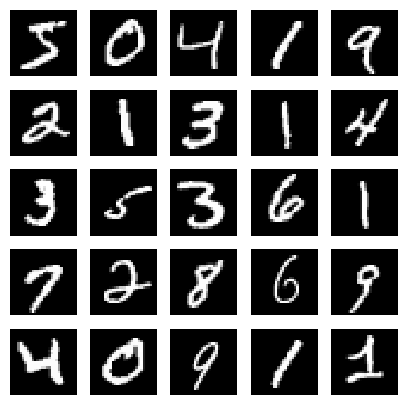

In [27]:
train_dataset,eval_dataset,all_dataset=get_data(task)
data_processor = DataProcessor()
train_data_processed = data_processor.process_data(train_dataset).to(device)
train_dataset_processed = data_processor.to_dataset(train_data_processed)
train_loader = DataLoader(dataset=train_dataset_processed, batch_size=1024, shuffle=False)

In [28]:
def train_eval_ncp(sampler,data_loader,epochs=10,bs=1024,lr=0.001):
    binary_classifier=Binary_Classifier(ResidualBlockA,ResidualBlockB,3 if task=='cifar' else 1).to(device)
    optimizer=torch.optim.Adam(binary_classifier.parameters(),lr=lr)
    criterion=nn.BCELoss()
    for epoch in range(epochs):
        acc=[]
        losses=[]
        for batch in data_loader:
            num_samples=len(batch['data'])
            q=sampler.model(batch).recon_x
            # p_=torch.tensor(gmm_sampler.gmm.sample(num_samples)[0]).type(torch.float).to(device)
            p=sampler.sample(num_samples)
            input=torch.cat((q,p),dim=0)
            labels=torch.cat((torch.ones(num_samples),torch.zeros(num_samples))).to(device)
            out=binary_classifier(input).squeeze()
            loss=criterion(out,labels) 
            acc.append(np.mean(np.array(out.cpu()>0.5)==np.array(labels.cpu())))
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.cpu().item())
            optimizer.step()
        print('Eopoch :{} | Acc : {:.3f} | Loss : {:.3f} '.format(epoch,np.mean(acc),np.mean(losses)))

    ncp_vae=NCP_VAE(sampler,binary_classifier)
    fid_scores=[]
    # print('acc: ',np.mean(acc))
    print("Evaluation ncp_vae")
    for i in range(1):
        fid_score=ncp_vae.evaluate(torch.tensor(all_dataset),len(all_dataset))['FID'].cpu().item()
        fid_scores.append(fid_score)
    print('FID : {}, avg: {:.3F}'.format(fid_scores,np.mean(fid_scores)))
    return ncp_vae
    


In [33]:
ncp_vae_sampler_gmm=train_eval_ncp(sampler_gmm,train_loader,50,lr=0.01)

Eopoch :0 | Acc : 0.532 | Loss : 0.690 
Eopoch :1 | Acc : 0.559 | Loss : 0.684 
Eopoch :2 | Acc : 0.566 | Loss : 0.680 
Eopoch :3 | Acc : 0.571 | Loss : 0.679 
Eopoch :4 | Acc : 0.579 | Loss : 0.675 
Eopoch :5 | Acc : 0.583 | Loss : 0.674 
Eopoch :6 | Acc : 0.588 | Loss : 0.670 
Eopoch :7 | Acc : 0.598 | Loss : 0.665 
Eopoch :8 | Acc : 0.600 | Loss : 0.663 
Eopoch :9 | Acc : 0.605 | Loss : 0.660 
Eopoch :10 | Acc : 0.615 | Loss : 0.656 
Eopoch :11 | Acc : 0.616 | Loss : 0.654 
Eopoch :12 | Acc : 0.621 | Loss : 0.649 
Eopoch :13 | Acc : 0.623 | Loss : 0.647 
Eopoch :14 | Acc : 0.628 | Loss : 0.642 
Eopoch :15 | Acc : 0.632 | Loss : 0.639 
Eopoch :16 | Acc : 0.633 | Loss : 0.637 
Eopoch :17 | Acc : 0.639 | Loss : 0.633 
Eopoch :18 | Acc : 0.640 | Loss : 0.631 
Eopoch :19 | Acc : 0.643 | Loss : 0.629 
Eopoch :20 | Acc : 0.646 | Loss : 0.626 
Eopoch :21 | Acc : 0.644 | Loss : 0.626 
Eopoch :22 | Acc : 0.646 | Loss : 0.624 
Eopoch :23 | Acc : 0.650 | Loss : 0.622 
Eopoch :24 | Acc : 0.650 |

/tmp/ipykernel_749602/1367406280.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fid_score=ncp_vae.evaluate(torch.tensor(all_dataset),len(all_dataset))['FID'].cpu().item()
100%|██████████| 59/59 [00:55<00:00,  1.07it/s]


FID : [23.741308212280273], avg: 23.741


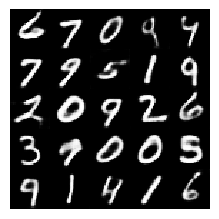

In [32]:
plot_figures(ncp_vae_sampler_gmm.sample(25),output_dir,'ncp_rae_gmm_output')

## Visualizing reconstructions

In [ ]:
reconstructions = trained_model.reconstruct(eval_dataset[:25].to(device)).detach().cpu()

In [ ]:
# show reconstructions
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(reconstructions[i*5 + j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

In [ ]:
# show the true data
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(eval_dataset[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

## Visualizing interpolations

In [ ]:
interpolations = trained_model.interpolate(eval_dataset[:5].to(device), eval_dataset[5:10].to(device), granularity=10).detach().cpu()

In [ ]:
# show interpolations
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))

for i in range(5):
    for j in range(10):
        axes[i][j].imshow(interpolations[i, j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

In [ ]:
sample_num=100000
z_prior=gmm_sampler.gmm.sample(sample_num)[0]
z_posterior=gmm_sampler.model(train_dataset_processed[:sample_num]).z.detach().cpu()
z_ncp=ncp_vae.sample_from_ncp(sample_num).cpu()
p_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(z_prior)
q_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(z_posterior)
p_ncp_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(z_ncp)




In [ ]:
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
import numpy as np

# Load and format data
# dem = cbook.get_sample_data('jacksboro_fault_dem.npz', np_load=True)
z = q_embedded
nrows, ncols = z.shape
x = np.linspace(np.min(z[:,0]),np.max(z[:,0]), ncols)
y = np.linspace(np.min(z[:,1]), np.max(z[:,1]), nrows)
x, y = np.meshgrid(x, y)

region = np.s_[5:50, 5:50]
x, y, z = x[region], y[region], z[region]

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

plt.show()